### DEFINIR EL PROBLEMA

### IMPORTANCIA



In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_tickets = pd.read_csv('../tracking/data/data_processed/tickets_classification_eng_1.csv')

In [3]:
df_tickets.head()

complaint_what_happened  \
0  Good morning my name is XXXX XXXX and I apprec...   
1  I upgraded my XXXX XXXX card in XX/XX/2018 and...   
2  Chase Card was reported on XX/XX/2019. However...   
3  On XX/XX/2018, while trying to book a XXXX  XX...   
4  my grand son give me check for {$1600.00} i de...   

                               ticket_classification  \
0                 Debt collection + Credit card debt   
1  Credit card or prepaid card + General-purpose ...   
2  Credit reporting, credit repair services, or o...   
3  Credit reporting, credit repair services, or o...   
4     Checking or savings account + Checking account   

                                      processed_text  
0  morn name appreci chase bank cardmemb servic c...  
1  card anniversari date inform order account ann...  
2  card report howev submit ident consent fraudul...  
3  2018 book ticket offer ticket appli card infor...  
4  son check deposit account fund bank account mo...

In [4]:
df_tickets = df_tickets.dropna()

In [5]:
df_tickets.isnull().sum()

complaint_what_happened    0
ticket_classification      0
processed_text             0
dtype: int64

In [6]:
df_tickets.sample(10)

complaint_what_happened  \
2126   Chase I want to inform you that I submitted a ...   
10636  This is the second time I ask CFPB to interven...   
17571  I had a Moving Company called XXXX scam me, on...   
14514  On XX/XX/XXXX, I, XXXX XXXX XXXX XXXX purchase...   
14405  Someone else 's {$330000.00} investment accoun...   
15732  I purchased my first home on XXXX XXXX 2015. I...   
14439  Over a year ago my accounts were closed by Cha...   
8090   On XX/XX/2020, while traveling oversea in XXXX...   
95     On XXXX/XXXX/2019, my Chase Sapphire Credit Ca...   
9532   Chase is marking late for payment that are not...   

                                   ticket_classification  \
2126   Credit card or prepaid card + General-purpose ...   
10636  Credit reporting, credit repair services, or o...   
17571         Bank account or service + Checking account   
14514  Mortgage + Home equity loan or line of credit ...   
14405         Bank account or service + Checking account   
15732  Bank account or service + Other bank product/s...   
14439     Checking or savings account + Checking account   
8090   Credit card or prepaid card + General-purpose ...   
95     Credit card or prepaid card + General-purpose ...   
9532                           Mortgage + Other mortgage   

                                          processed_text  
2126   chase inform submit complaint equifax comment ...  
10636  time issu complaint  fifth time chase bank thi...  
17571  move compani call scam day bank check check ra...  
14514   home  tx femal name marri home equiti line cr...  
14405  someon account attach account chase bank remov...  
15732  purchas home use  tax payment check payabl tre...  
14439  year chase account year decid account time job...  
8090   2020 oversea  pickpocket sapphir reserv card a...  
95     2019 credit card receiv charg amount  author 2...  
9532   mark payment cash payment branch charg erron f...

In [7]:
df_tickets.ticket_classification.unique()

array(['Debt collection + Credit card debt',
       'Credit card or prepaid card + General-purpose credit card or charge card',
       'Credit reporting, credit repair services, or other personal consumer reports + Other personal consumer report',
       'Credit reporting, credit repair services, or other personal consumer reports + Credit reporting',
       'Checking or savings account + Checking account',
       'Vehicle loan or lease + Loan',
       'Money transfer, virtual currency, or money service + Domestic (US) money transfer',
       'Checking or savings account + Savings account',
       'Mortgage + Conventional home mortgage',
       'Mortgage + Home equity loan or line of credit (HELOC)',
       'Student loan + Private student loan',
       'Debt collection + I do not know', 'Consumer Loan + Vehicle loan',
       'Mortgage + FHA mortgage',
       'Money transfer, virtual currency, or money service + Mobile or digital wallet',
       'Money transfer, virtual currency, or mon

In [8]:
df_tickets.to_csv('data_tickets_classification_preprocessed.csv', index=False) 

In [9]:
def analyze_ngrams(df: pd.DataFrame, 
                   name_column_text: str, 
                   name_column_target : str, 
                   top_n=10, 
                   ngram_range=(2, 3)) -> None:
    """This function is used to analyze the n-grams of the text
    Args:
        df (pd.DataFrame): DataFrame with the text to analyze
        ngram_range (tuple, optional): Range of n-grams to analyze. Defaults to (2, 3).
        top_n (int, optional): Number of n-grams to return. Defaults to 10.
    Returns:
        None"""
    unique_categories = df[name_column_target].unique()[:10]

    for category in unique_categories:
        filtered_text = df[df[name_column_target] == category][name_column_text]
        filtered_text = filtered_text.astype(str)  # Asegúrate de que el texto esté en formato string
        
        # crear un objeto CountVectorizer para n-gramas
        vectorizer = CountVectorizer(ngram_range=ngram_range)
        X = vectorizer.fit_transform(filtered_text)
        
        # obtener los n-gramas y su frecuencia
        ngram_freq = list(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0]))
        ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_n]
    
        print(f"Top {top_n} n-grams for category '{category}':")
        for ngram, freq in ngram_freq:
            print(f"{ngram}: {freq} times")
        print("\n")


In [10]:
def generate_category_wordclouds(df: pd.DataFrame, 
                                 name_column_text: str, 
                                 name_column_target: str):
    """This function is used to generate the wordclouds of the text"""
    unique_categories = df[name_column_target].unique()[:10]
    for category in unique_categories:
        filtered_text = ' '.join(df[df[name_column_target] == category][name_column_text])
        print(f" unique tokens for class: {len(set(filtered_text.split()))}")
        if filtered_text:
            wordcloud = WordCloud(width=800, height=600, background_color='white',
                                  colormap='viridis', max_words=150, contour_color='steelblue',
                                  contour_width=2, prefer_horizontal=0.8).generate(filtered_text)
            plt.figure(figsize=(8, 8))  # Tamaño de la figura para mejorar la resolución
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f"Word Cloud for Category: {category}")
            plt.show()

 unique tokens for class: 2094


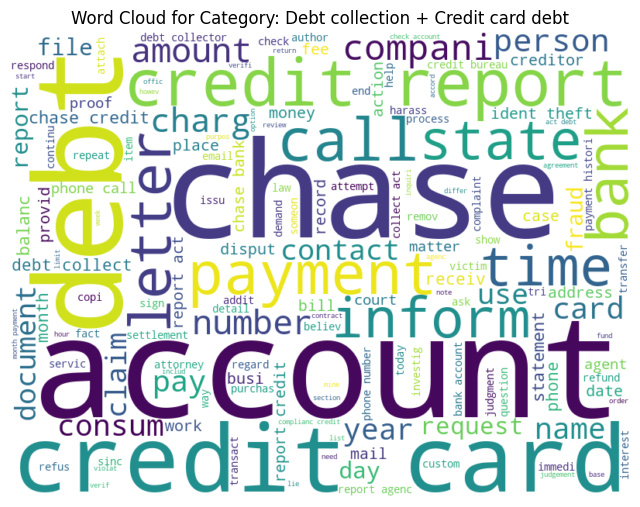

 unique tokens for class: 7519


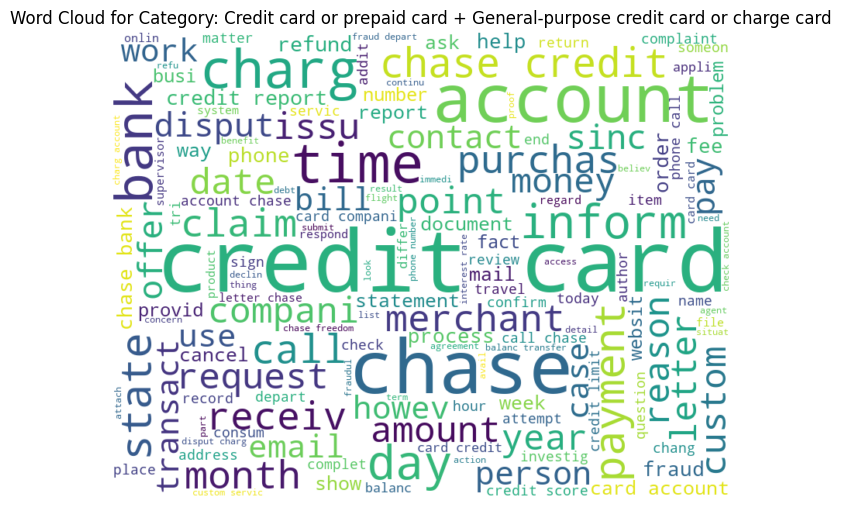

 unique tokens for class: 741


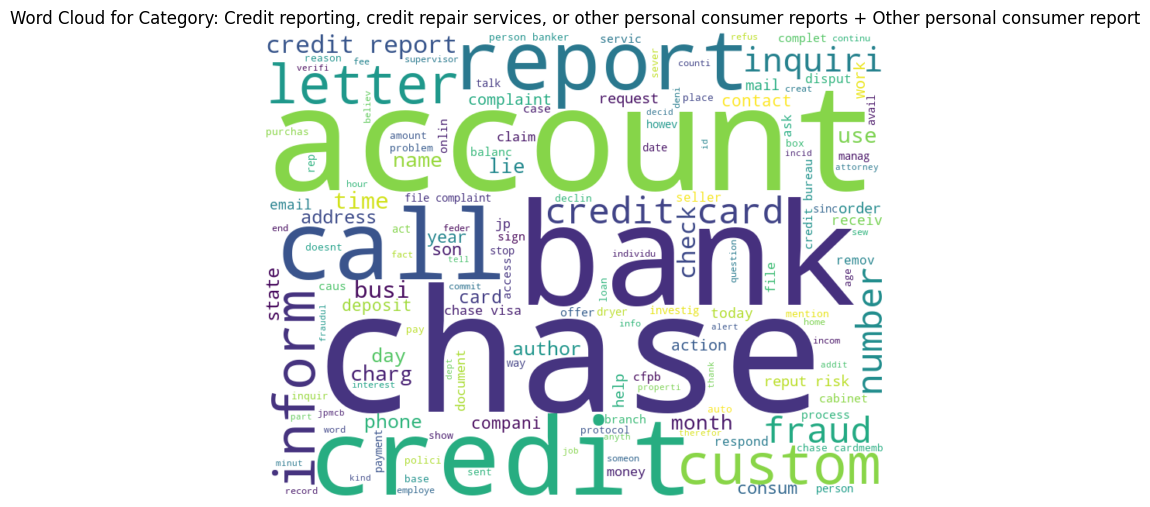

 unique tokens for class: 3584


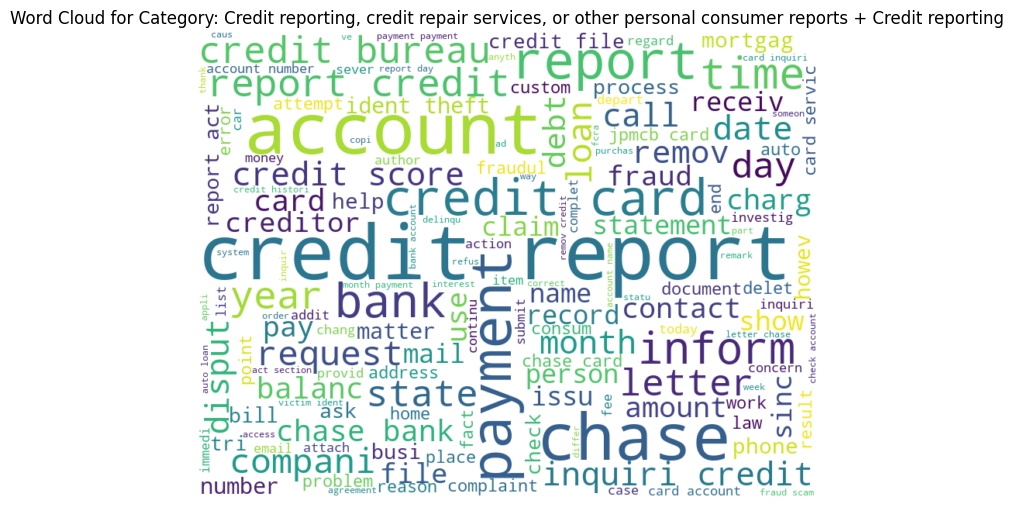

 unique tokens for class: 6350


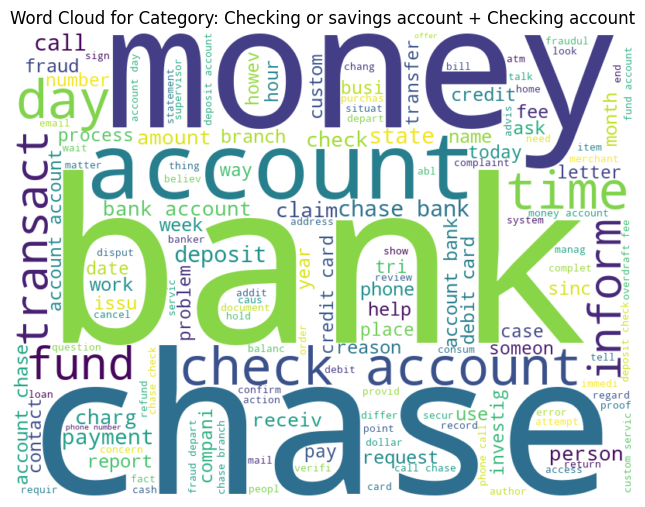

 unique tokens for class: 1726


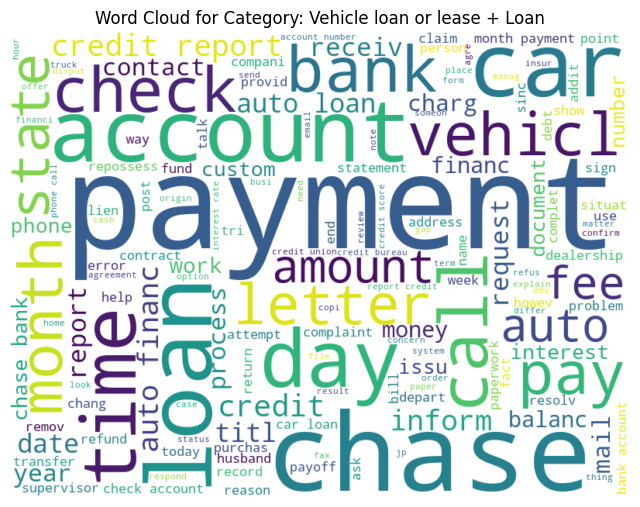

 unique tokens for class: 2154


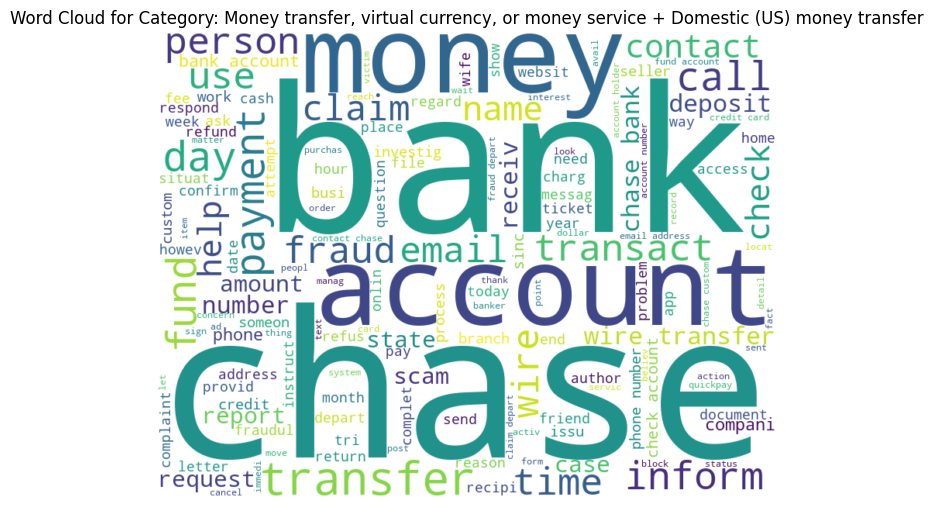

 unique tokens for class: 1738


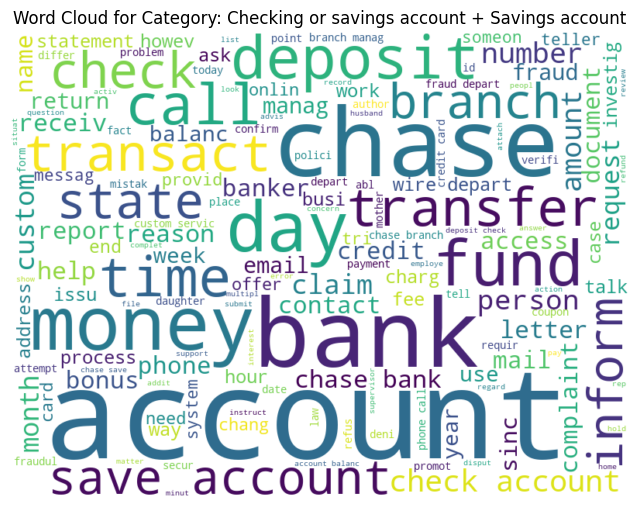

 unique tokens for class: 4109


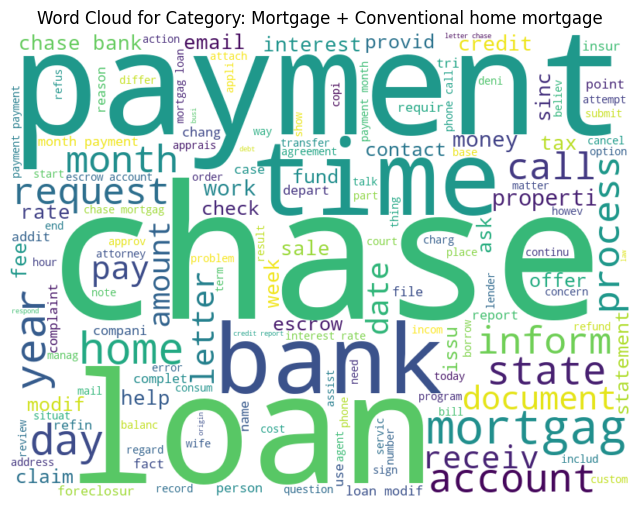

 unique tokens for class: 1857


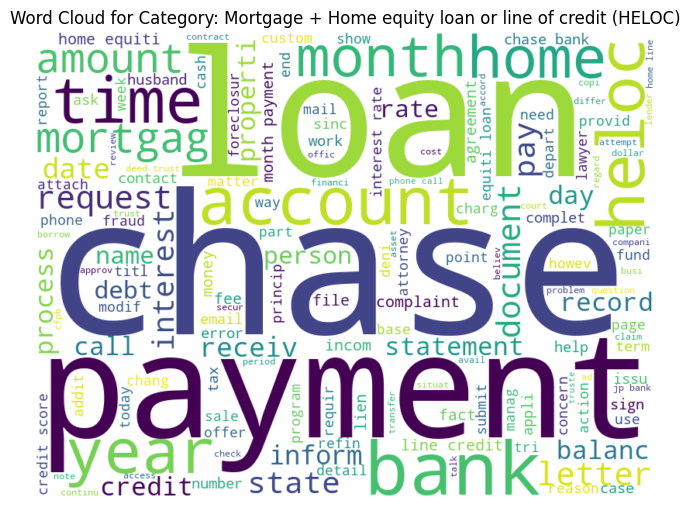

In [11]:
generate_category_wordclouds(df = df_tickets, 
                             name_column_target= "ticket_classification", 
                             name_column_text= "processed_text")

In [12]:
def plot_ngrams(df: pd.DataFrame, 
                name_column_text: str, 
                name_column_target: str, 
                ngram_range=(2, 3), 
                top_n=5) -> None:
    """This function is used to plot the n-grams of the text
    Args:
        df (pd.DataFrame): DataFrame with the text to analyze
        ngram_range (tuple, optional): Range of n-grams to analyze. Defaults to (2, 3).
        top_n (int, optional): Number of n-grams to return. Defaults to 10."""
    unique_categories = df[name_column_target].unique()[:8]

    fig, axs = plt.subplots(len(unique_categories), 2, figsize=(12, 2 * len(unique_categories)))

    for i, category in enumerate(unique_categories):
        filtered_text = df[df[name_column_target] == category][name_column_text]
        filtered_text = filtered_text.astype(str) 
        
        vectorizer = CountVectorizer(ngram_range=ngram_range)
        X = vectorizer.fit_transform(filtered_text)
        
        # Obtener los n-gramas y su frecuencia
        ngram_freq = list(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0]))
        ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)
        
        bigrams = [ngram[0] for ngram in ngram_freq if len(ngram[0].split()) == 2][:top_n]
        bigram_frequencies = [ngram[1] for ngram in ngram_freq if len(ngram[0].split()) == 2][:top_n]
        
        trigrams = [ngram[0] for ngram in ngram_freq if len(ngram[0].split()) == 3][:top_n]
        trigram_frequencies = [ngram[1] for ngram in ngram_freq if len(ngram[0].split()) == 3][:top_n]

        if bigrams:
            axs[i, 0].barh(bigrams, bigram_frequencies, color='skyblue')
            axs[i, 0].set_xlabel('Frequency')
            axs[i, 0].set_title(f'Top {top_n} Bigrams:\n{category[:45]}...', fontsize=6)
            axs[i, 0].invert_yaxis()

            for j, freq in enumerate(bigram_frequencies):
                axs[i, 0].text(freq, j, str(freq), ha='left', va='center')

        if trigrams:
            axs[i, 1].barh(trigrams, trigram_frequencies, color='salmon')
            axs[i, 1].set_xlabel('Frequency')
            axs[i, 1].set_title(f'Top {top_n} Trigrams:\n{category[:45]}...', fontsize=6)
            axs[i, 1].invert_yaxis()

            for j, freq in enumerate(trigram_frequencies):
                axs[i, 1].text(freq, j, str(freq), ha='left', va='center')

    plt.subplots_adjust(hspace=0.5)
    plt.tight_layout()
    plt.show()


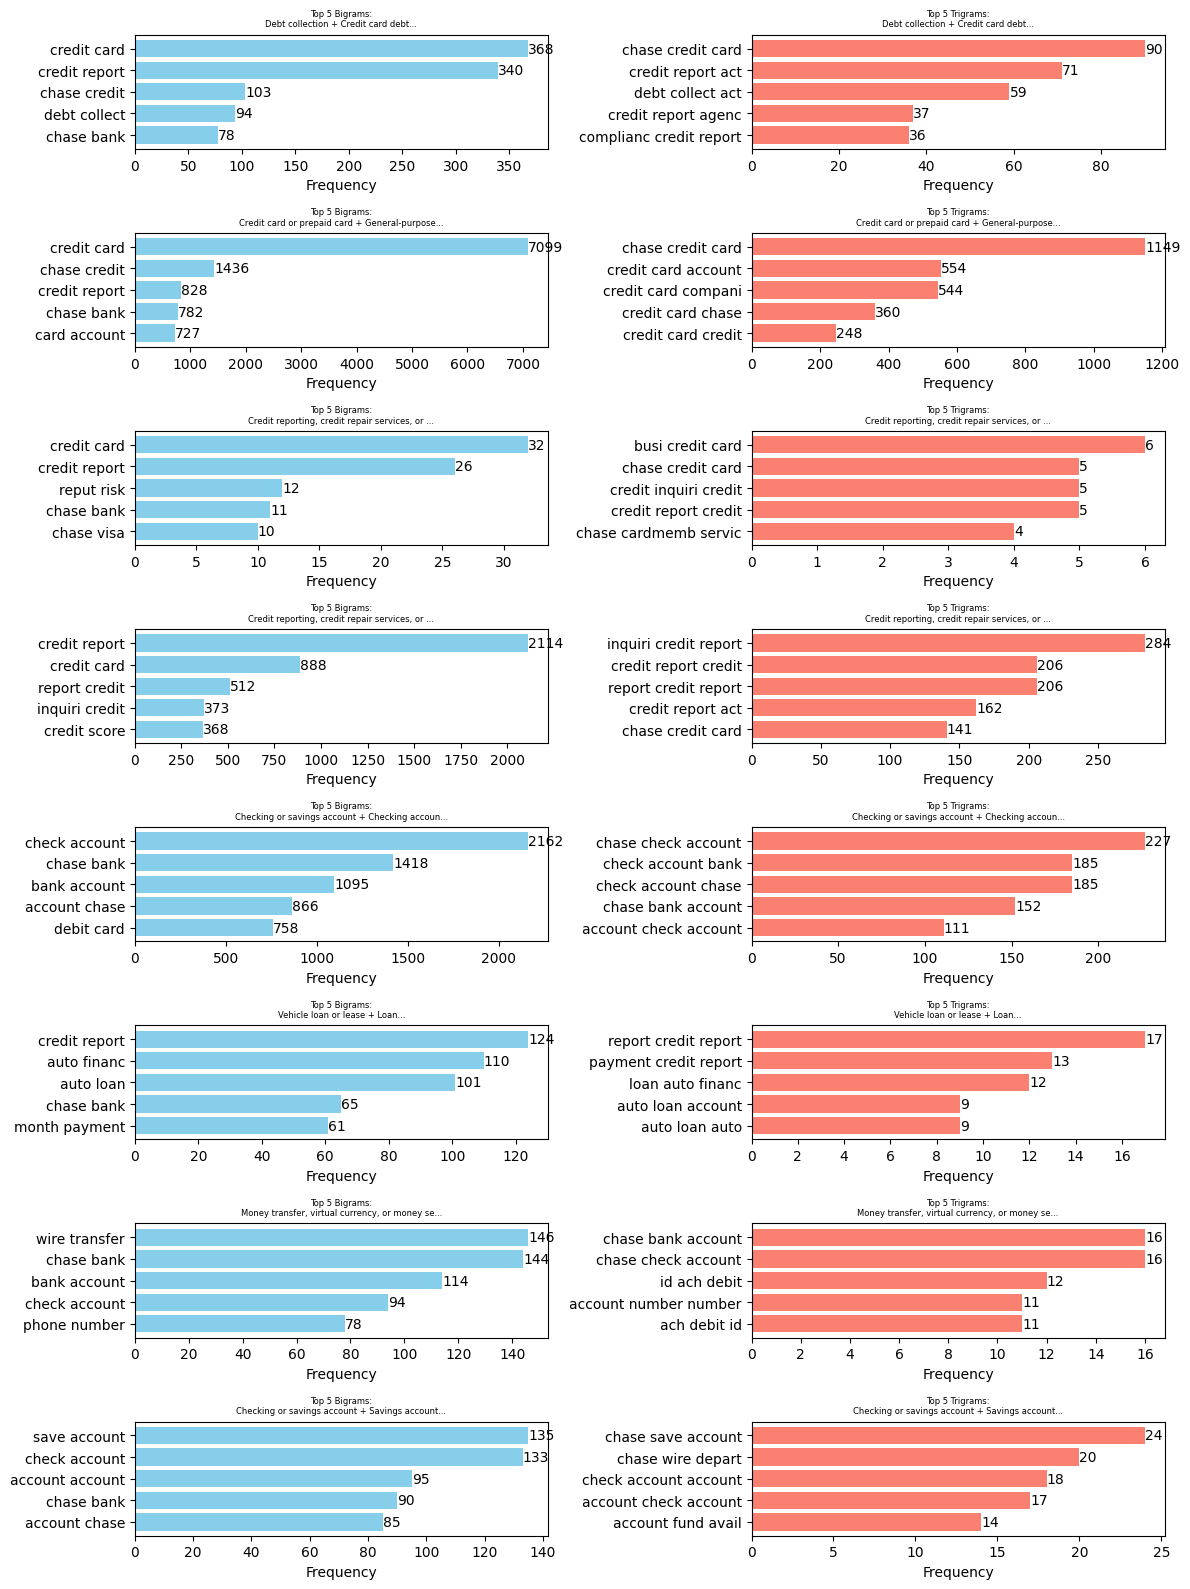

In [13]:
plot_ngrams(df_tickets, "processed_text", "ticket_classification")

In [14]:
df_tickets['token_count'] = df_tickets['processed_text'].apply(len)

In [15]:
df_tickets['token_count'].describe()

count    18961.000000
mean       413.505564
std        462.124731
min          4.000000
25%        159.000000
50%        290.000000
75%        516.000000
max      11194.000000
Name: token_count, dtype: float64

En nuestro conjunto de datos con 20,000 registros, la longitud promedio de los tokens es de alrededor de 413 tokens. Hay cierta variabilidad con una desviación estándar de aproximadamente 462 tokens. 


 ####  ✨✨ Importancia de la Longitud del Texto en Modelos de Procesamiento del Lenguaje Natural (NLP)

Al entrenar modelos de NLP, la longitud del texto en tus datos es como el tamaño de las porciones de pizza que le das a diferentes robots lectores. Imagina que tienes una pandilla de robots diseñados para leer mensajes: algunos mensajes son como mini notas y otros son como manuscritos antiguos.

Aquí está la clave: para que estos robots (¡y los modelos de NLP!) trabajen de manera eficiente y efectiva, es esencial tener mensajes de longitud similar. Cuando los mensajes son de longitud variada, algunos robots podrían sobrecargarse y otros podrían quedarse con espacio vacío en sus bandejas.

Piénsalo como darles a estos robots bandejas de tamaño fijo para ordenar los mensajes. Si los mensajes son muy largos, algunos robots tendrán dificultades para manejarlos, mientras que otros tendrán espacio de sobra. Pero si los mensajes son más consistentes en longitud, cada robot funcionará óptimamente.

En el mundo del NLP, los modelos, como las redes neuronales, funcionan mejor cuando los mensajes tienen una longitud más uniforme. Esto permite que el modelo aprenda patrones y relaciones entre palabras de manera más eficaz.

Considerar la longitud del texto es como darle a cada robot su bandeja perfectamente ajustada: les permite trabajar de manera más inteligente y eficiente. Así que, en tus modelos de NLP, ¡la longitud importa y mucho! Así que ten presente esto cuando estés trabajando con tus datos.


In [16]:
def plot_token_count_kde(df, column_name):
    """Plot a kernel density estimation (KDE) of token counts"""
    plt.figure(figsize=(8, 6))
    sns.kdeplot(df[column_name], color='skyblue', shade=True)
    plt.xlabel('Token Count')
    plt.ylabel('Density')
    plt.title('Distribution of Token Counts (KDE)')
    plt.grid(True)
    plt.show()

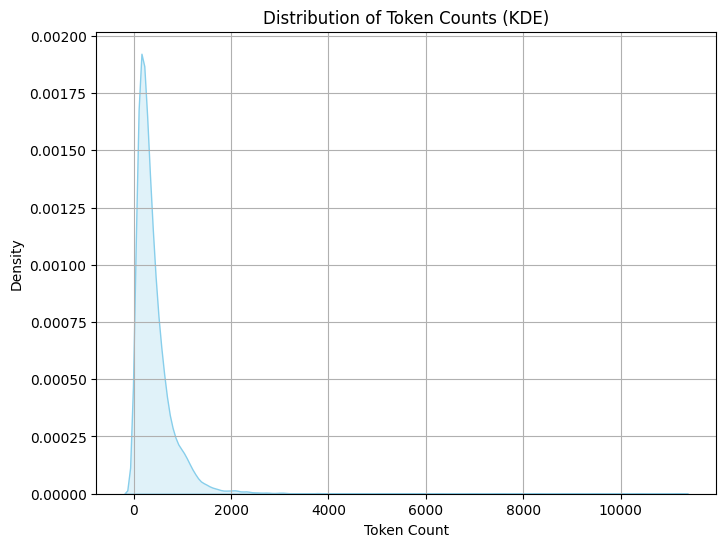

In [17]:
plot_token_count_kde(df_tickets, 'token_count')


In [18]:
def plot_count(data: pd.DataFrame, column: str) -> None:
    """This function is used to plot the distribution of the classes in the dataset
    Args:
        data (pd.DataFrame): DataFrame with the data to analyze
        column (str): Name of the column to plot"""
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(x=column, data=data, palette='viridis')  
    plt.title('Distribución de las clases en el dataset')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()

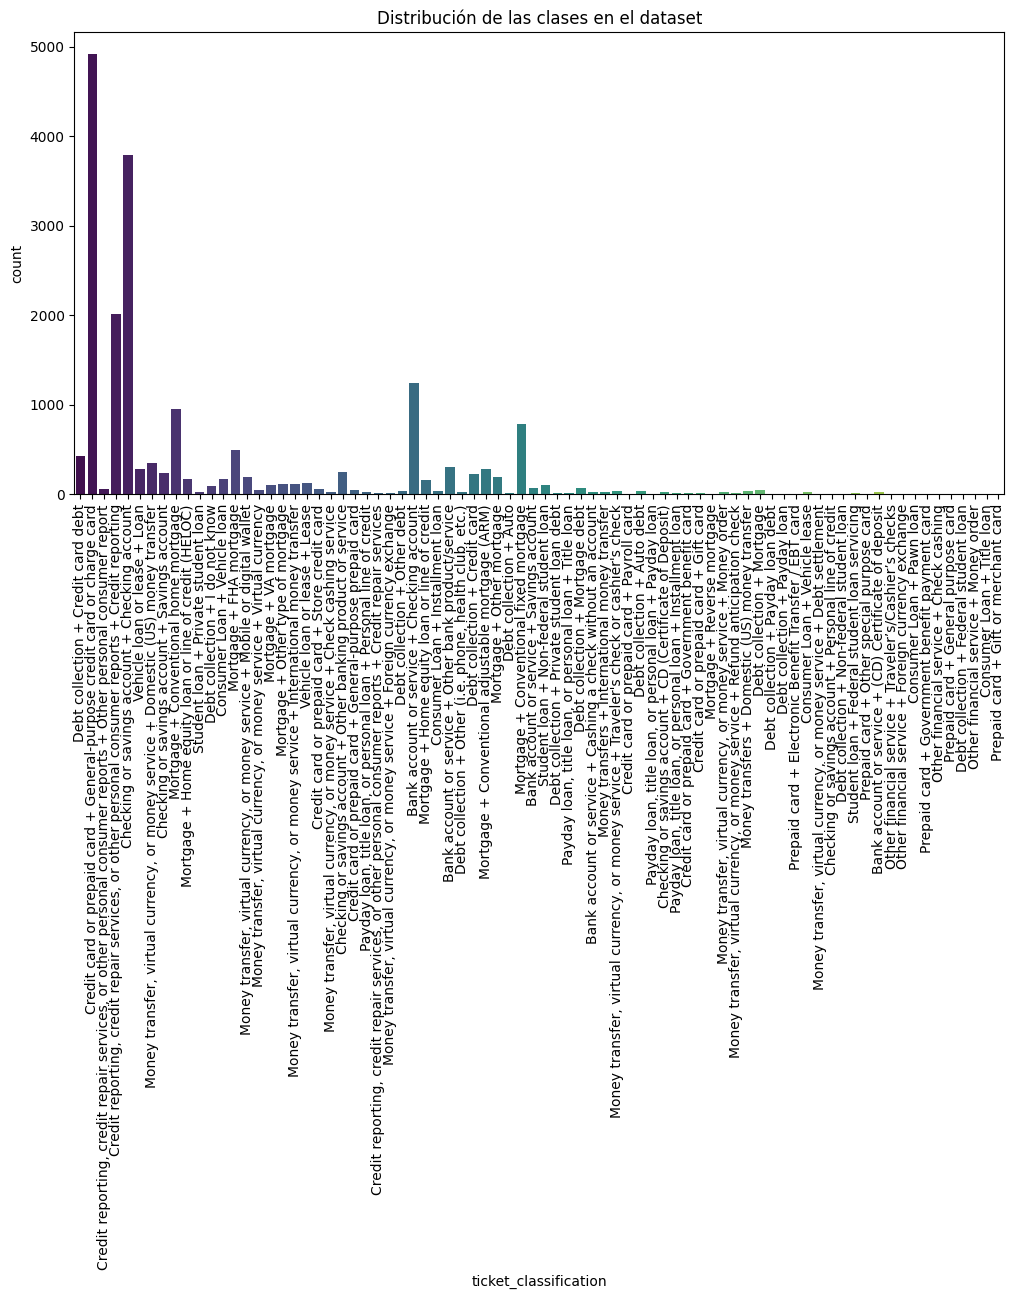

In [19]:
plot_count(df_tickets, 'ticket_classification')

In [20]:
len(df_tickets["ticket_classification"].unique())

78

##### Descubriendo Secretos del Lenguaje con NMF: ¡Explorando Temas Ocultos en Textos Mágicos! 🕵️‍♂️📚✨


Al explorar nuestros datos, nos enfrentamos a un conjunto considerable de alrededor de 78 labels o etiquetas para los tickets, representando una amplia gama de información. En este contexto, la aplicación de NMF (Factorización Matricial No Negativa) se convierte en un aliado crucial. NMF, en su papel de método analítico, actúa como un hábil decodificador lingüístico 🕵️‍♂️. Su función principal radica en descubrir patrones intrínsecos en estos datos densos y organizar estos labels en temas coherentes y pertinentes. Esta técnica nos permite destilar la información, simplificando la complejidad inherente a estas múltiples etiquetas. De esta manera, al visualizar la gráfica de plots de labels, empleamos NMF para revelar la estructura subyacente, facilitando así una comprensión más profunda y clara de estos datos desafiantes. Es decir, con muchas etiquetas, la interpretación se vuelve más compleja. Identificar patrones o relaciones significativas entre tantas etiquetas puede ser desafiante y requerir análisis detallado por lo que después tendremos que extraer la clasficación de los tickets más significativos para el negocio e incluir en el pipeline una task para el feature extración de nuestros datos ya previamente preprocesados y limpiados. 

### Data post procesamiento topic modeling ✨

In [20]:
data_prep = pd.read_csv('data/data_prep.csv', index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: 'data/data_prep.csv'